<img src="https://raw.githubusercontent.com/dask/dask/main/docs/source/images/dask_horizontal.svg"
     width="60%"
     alt="Dask logo\" />

# Dask DataFrame

As we learned in our Dask Delayed notebook we can parallelize functions using `dask.delayed`, but luckily for us we have multiple Dask collections that already include a parallel version of multiple functions. In this notebook we will learn about the [Dask DataFrame](https://docs.dask.org/en/latest/dataframe.html), a Pandas DataFrame interface that will automatically build parallel computations for tabular data.

## When to use Dask DataFrames

Pandas is great for tabular datasets that fit in memory. If your data fits in memory then you should use Pandas. **Dask becomes useful when the dataset you want to analyze is larger than your machine's RAM** where you would normally run into `MemoryError`s.

```python
    MemoryError:  ...
```

During this tutorial, the example NYC dataset we're working with is only about 200MB so that you can download it in a reasonable time and exercises finish quickly, but Dask Dataframes will scale to datasets much larger than the memory on your local machine. 

# Getting started with Dask DataFrames

Let's use Dask DataFrame's to explore our NYC flight dataset. Dask's `read_csv` function will automatically example wildcard characters like `"*"` which can, for example, be used to load an entire directory of CSV files.

In [1]:
%run ../prep_data.py -d flights

data_dir='/Users/samia/Downloads/PyDataLondon2022/Friday_TS2_1330/data'


In [2]:
import os

files = os.path.join('../data', 'nycflights', '*.csv')
files

'../data/nycflights/*.csv'

In [3]:
import dask.dataframe as dd

In [4]:
ddf = dd.read_csv(files,
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={"TailNum": str,
                        "CRSElapsedTime": float,
                        "Cancelled": bool})
ddf

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,object,float64,float64,float64,float64,float64,object,object,float64,float64,float64,bool,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Notice that the representation of the dataframe object contains no data - Dask has just done enough to read the start of the first file, and infer the column names and dtypes.

In [5]:
ddf.columns

Index(['Date', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime',
       'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime',
       'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest',
       'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'Diverted'],
      dtype='object')

In [6]:
ddf.dtypes

Date                 datetime64[ns]
DayOfWeek                     int64
DepTime                     float64
CRSDepTime                    int64
ArrTime                     float64
CRSArrTime                    int64
UniqueCarrier                object
FlightNum                     int64
TailNum                      object
ActualElapsedTime           float64
CRSElapsedTime              float64
AirTime                     float64
ArrDelay                    float64
DepDelay                    float64
Origin                       object
Dest                         object
Distance                    float64
TaxiIn                      float64
TaxiOut                     float64
Cancelled                      bool
Diverted                      int64
dtype: object

Dask DataFrames have an `.npartitions` attribute which tells you how many Pandas DataFrames make up a Dask DataFrame.

In [7]:
ddf.npartitions

10

In [8]:
ddf2 = ddf.repartition(partition_size='100MiB')

In [9]:
ddf2

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,object,float64,float64,float64,float64,float64,object,object,float64,float64,float64,bool,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## The Dask DataFrame data model

For the most part, a Dask DataFrame feels like a Pandas DataFrame. This is because, internally, **a Dask DataFrame is composed of many Pandas DataFrames**: 

<img src="http://dask.pydata.org/en/latest/_images/dask-dataframe.svg" width="50%">

Dask DataFrames are partitioned along their index into different **partitions** where each parition is a normal Pandas DataFrame. This is why driving the Dask car *can feel* like you're still driving the pandas car. But don't forget that you've entered the world of distributed computing now -- which means you've added a lot more complexity to the mix. You now need to consider things like concurrency, state, data duplicates, data loss, etc.

Luckily, with a high-level Collection like DataFrames, Dask handles most of these complicated questions for you. 

Dask DataFrames implement a well-used portion of the Pandas API which are backed by blocked algorithms that allow for parallel and out-of-core computation. For more details about what Pandas operations are implemented in Dask, check the [Dask DataFrame API documentation](http://docs.dask.org/en/latest/dataframe-api.html). 

For many purposes Dask DataFrames can serve as drop-in replacements for Pandas DataFrames. Much like the Dask Delayed interface, Dask DataFrames are lazily evaluated. You can use use the DataFrame API to automatically build up a task graph representing complex computations and then call `compute()` to to evaluate the graph in parallel. 

> #### Reading Tip
For a great discussion of the pro's and con's of various pandas-like syntaxes for distributed computing, I recommend reading ["Why Pandas-like interfaces are Sub-optimal for Distributed Computing"](https://towardsdatascience.com/why-pandas-like-interfaces-are-sub-optimal-for-distributed-computing-322dacbce43) by Kevin Kho and Han Wang.

## Task Graphs

Let's look at the task graph for our Dask DataFrame to get a sense for where these partitions are coming from:

In [ ]:
ddf.visualize()

Each partition in our Dask DataFrame is the result of calling Pandas' `read_csv` on an input CSV file in our dataset.

We can view the start of the data with `df.head()`

In [ ]:
ddf.head(10)

`.head()` triggers a computation to show the first 10 rows of the DataFrame.

# Computations with Dask DataFrames

Since Dask DataFrames implement a Pandas-like API, we can write familiar looking Pandas code using our Dask DataFrames. For example, let's compute the largest flight departure delay.

In Pandas we would do this by iterating over each file to find the individual maximums and then find the final maximum over the individual maximums.

```python
maxes = []
for fn in filenames:
    df = pd.read_csv(fn)
    maxes.append(df["DepDelay"].max())

final_max = max(maxes)
```

We could wrap the `pd.read_csv` with `dask.delayed` so that it runs in parallel. But, we're still dealing with loops, intermediate results (one per file) and the final reduction (max of the intermediate maxes). Thankfully, we can do this with Dask DataFrames using Pandas-like code by doing:

In [10]:
max_delay = ddf["DepDelay"].max()

In [11]:
max_delay

dd.Scalar<series-..., dtype=float64>

The above cell looks exactly like what we would do using Pandas and constructs a task graph that we can compute in parallel. Let's look at the task graph to get a feel for how Dask's blocked algorithms work:

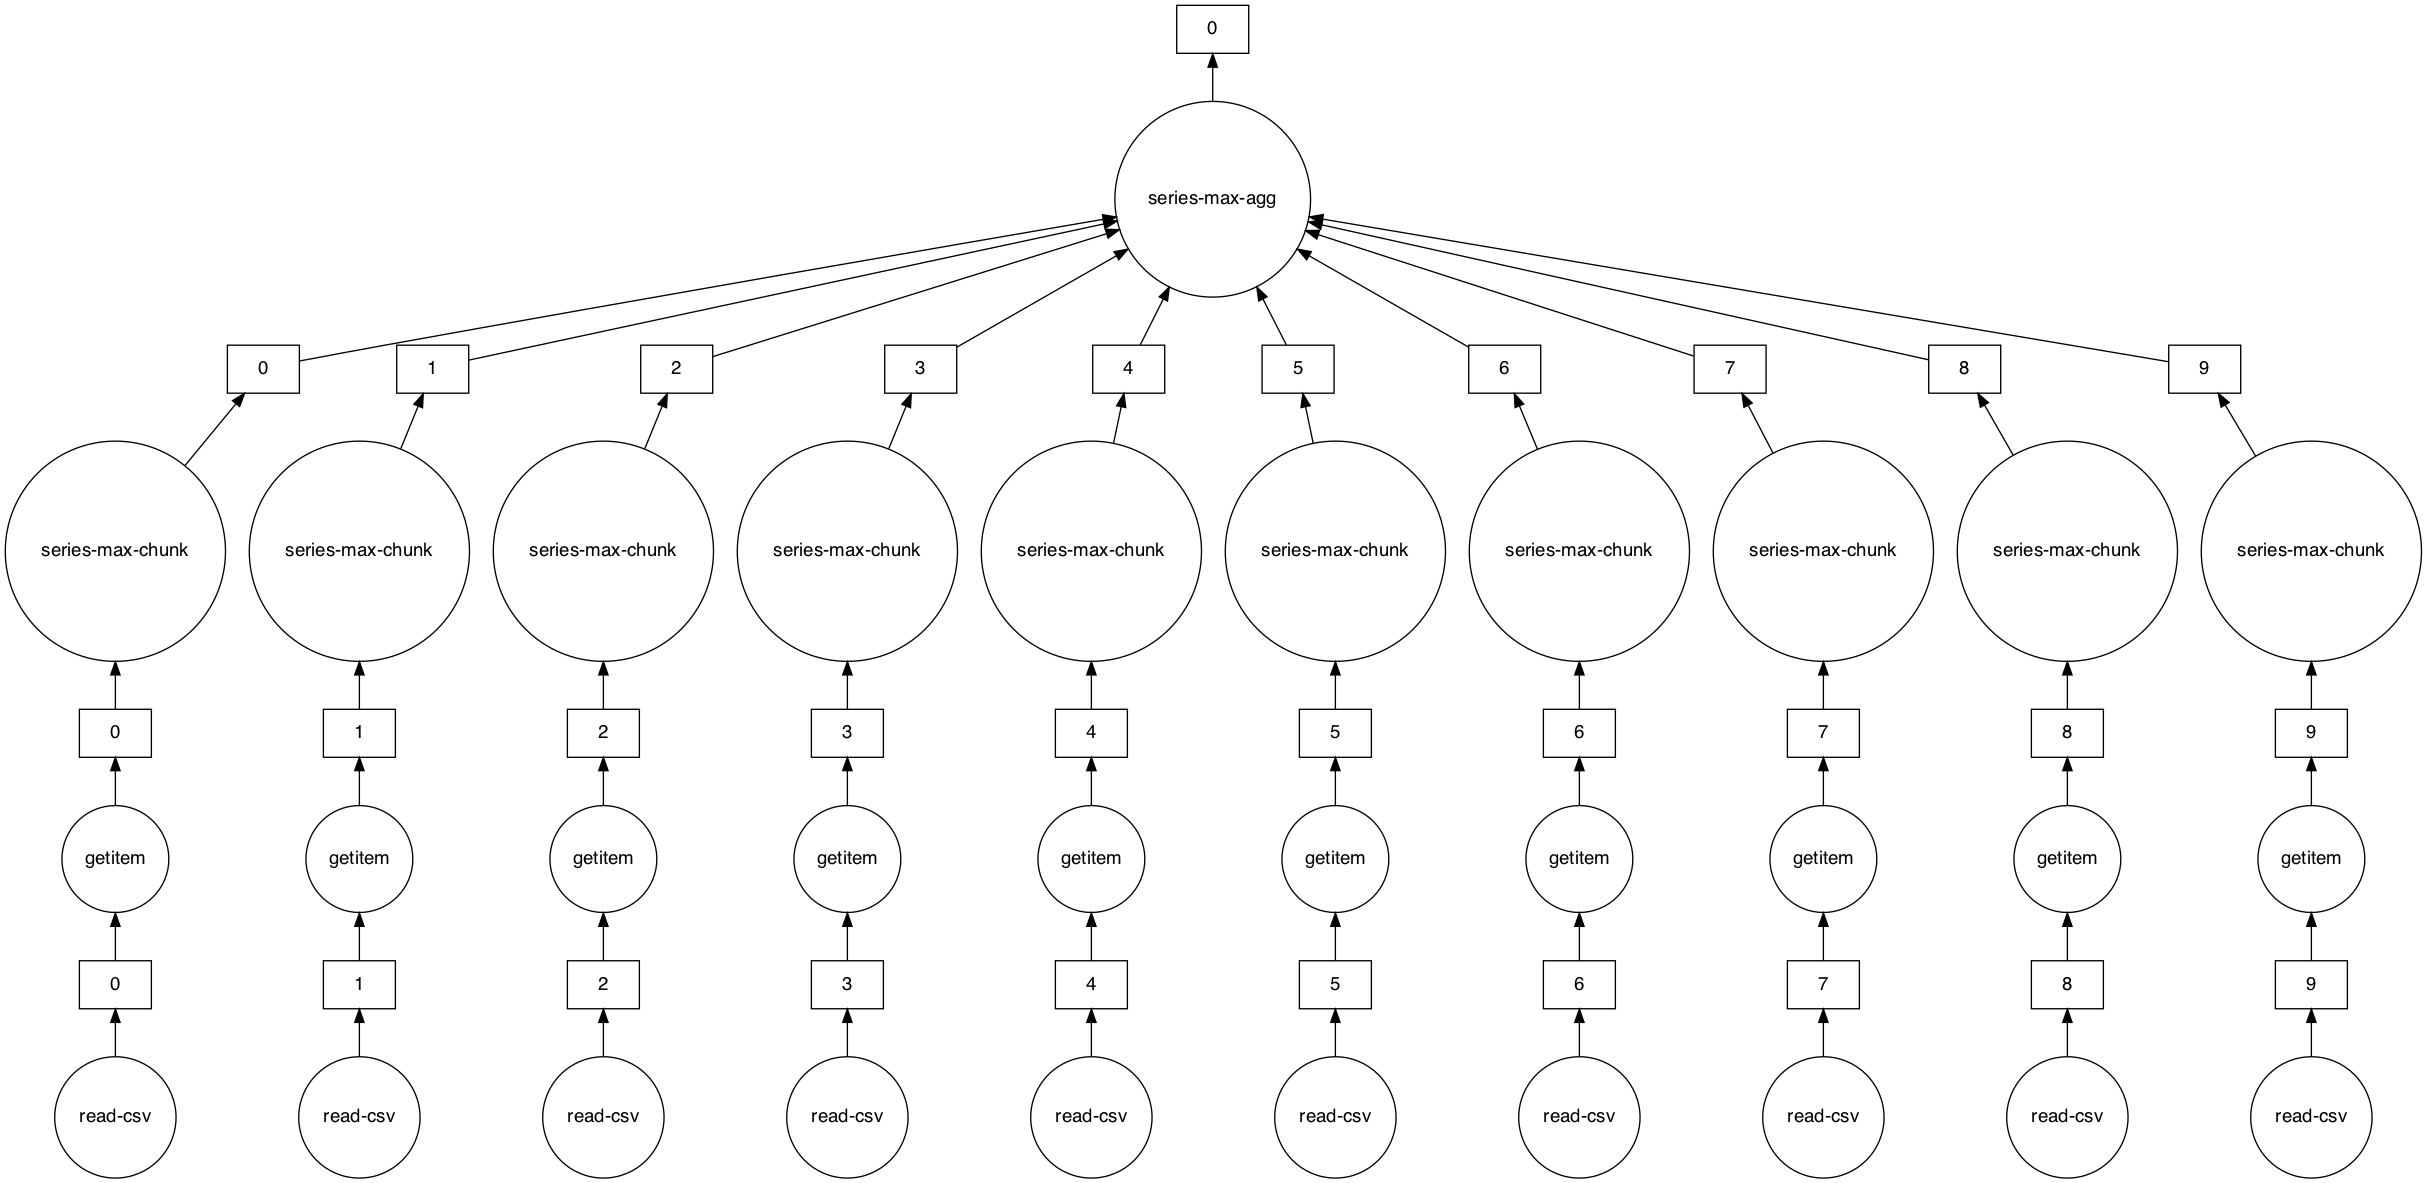

In [12]:
max_delay.visualize()

Some things to note:

1.  Up until this point everything is lazy. To evaluate the result for `max_delay`, call its `compute()` method:
2.  Dask will delete intermediate results (like the full pandas DataFrame for each file) as soon as possible.
    -  This lets us handle datasets that are larger than memory
    -  This means that repeated computations will have to load all of the data in each time 

In [13]:
%%time 
max_delay.compute()

CPU times: user 4.5 s, sys: 799 ms, total: 5.3 s
Wall time: 2.27 s


1435.0

## Pandas' like computations

Let's see couple of examples on how the API for Dask DataFrames is the same than Pandas. If you are comfortable with Pandas, the following operations will look very familiar, except we will need to add the `compute()` to get the results wanted.

### Example 1: Total of non-cancelled flights taken

Notice that there is a column in our DataFrame called `"Cancelled"` that is a boolean. 

In [14]:
(~ddf["Cancelled"]).sum().compute()

2540961

### Example 2: Total of non-cancelled flights taken by airport

We should select the non-canceled flights, use the operation `groupby` on the `"Origin"` column and finally use `count` to get the detailed per airport.

In [15]:
ddf[~ddf["Cancelled"]].groupby("Origin")["Origin"].count().compute()

Origin
EWR    1139451
JFK     427243
LGA     974267
Name: Origin, dtype: int64

### Exercise 1: What is the average departure delay from each airport?

Uncomment and run the cell below to see the solution

In [16]:
# %load ./solutions/dataframe-ex-1.py
ddf.groupby("Origin")["DepDelay"].mean().compute()

### Exercise 2: What day of the week has the worst average departure delay?

In [17]:
# %load ./solutions/dataframe-ex-2.py
#solution
ddf.groupby("DayOfWeek")["DepDelay"].mean().idxmax().compute()

In [18]:
# %load ./solutions/dataframe-ex-2.py
#solution
ddf.groupby("DayOfWeek")["DepDelay"].mean().idxmax().compute()

## Performance tip: When to call .compute()

In the examples and exercises above, we sometimes perform the same operation more than once (e.g. `read_csv`). Dask DataFrames hashes the arguments, allowing duplicate computations to be shared, and only computed once. You can use `dask.compute()` to merge task graphs of multiple operations.

For example, let's compute the mean and standard deviation for departure delay of all non-canceled flights. Since Dask operations are lazy, those values aren't the final results until we `compute` them. They're just the recipe required to get the result.

If we compute them with two calls to compute, there is no sharing of intermediate computations.

In [19]:
non_cancelled = ddf[~ddf["Cancelled"]]
mean_delay = non_cancelled["DepDelay"].mean()
std_delay = non_cancelled["DepDelay"].std()

In [20]:
%%time
mean_delay_result = mean_delay.compute()
std_delay_result = std_delay.compute()

CPU times: user 8.99 s, sys: 948 ms, total: 9.94 s
Wall time: 4.28 s


Now, let's see how long it takes if we try computing `mean_delay` and `std_delay` with a single `compute()` call.

In [21]:
import dask

In [22]:
%%time
mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

CPU times: user 4.45 s, sys: 370 ms, total: 4.82 s
Wall time: 2.05 s


Using `dask.compute` takes roughly 1/2 the time. This is because the task graphs for both results are merged when calling `dask.compute`, allowing shared operations (like `read_csv`) to only be done once instead of twice. In particular, using `dask.compute` only does the following once:

- The calls to `read_csv`
- The filter (`df[~df["Cancelled"]]`)
- The `"DepDelay"` column indexing
- Some of the necessary reductions (`sum`, `count`)

To see what the merged task graphs between multiple results look like (and what's shared), you can use the `dask.visualize` function:

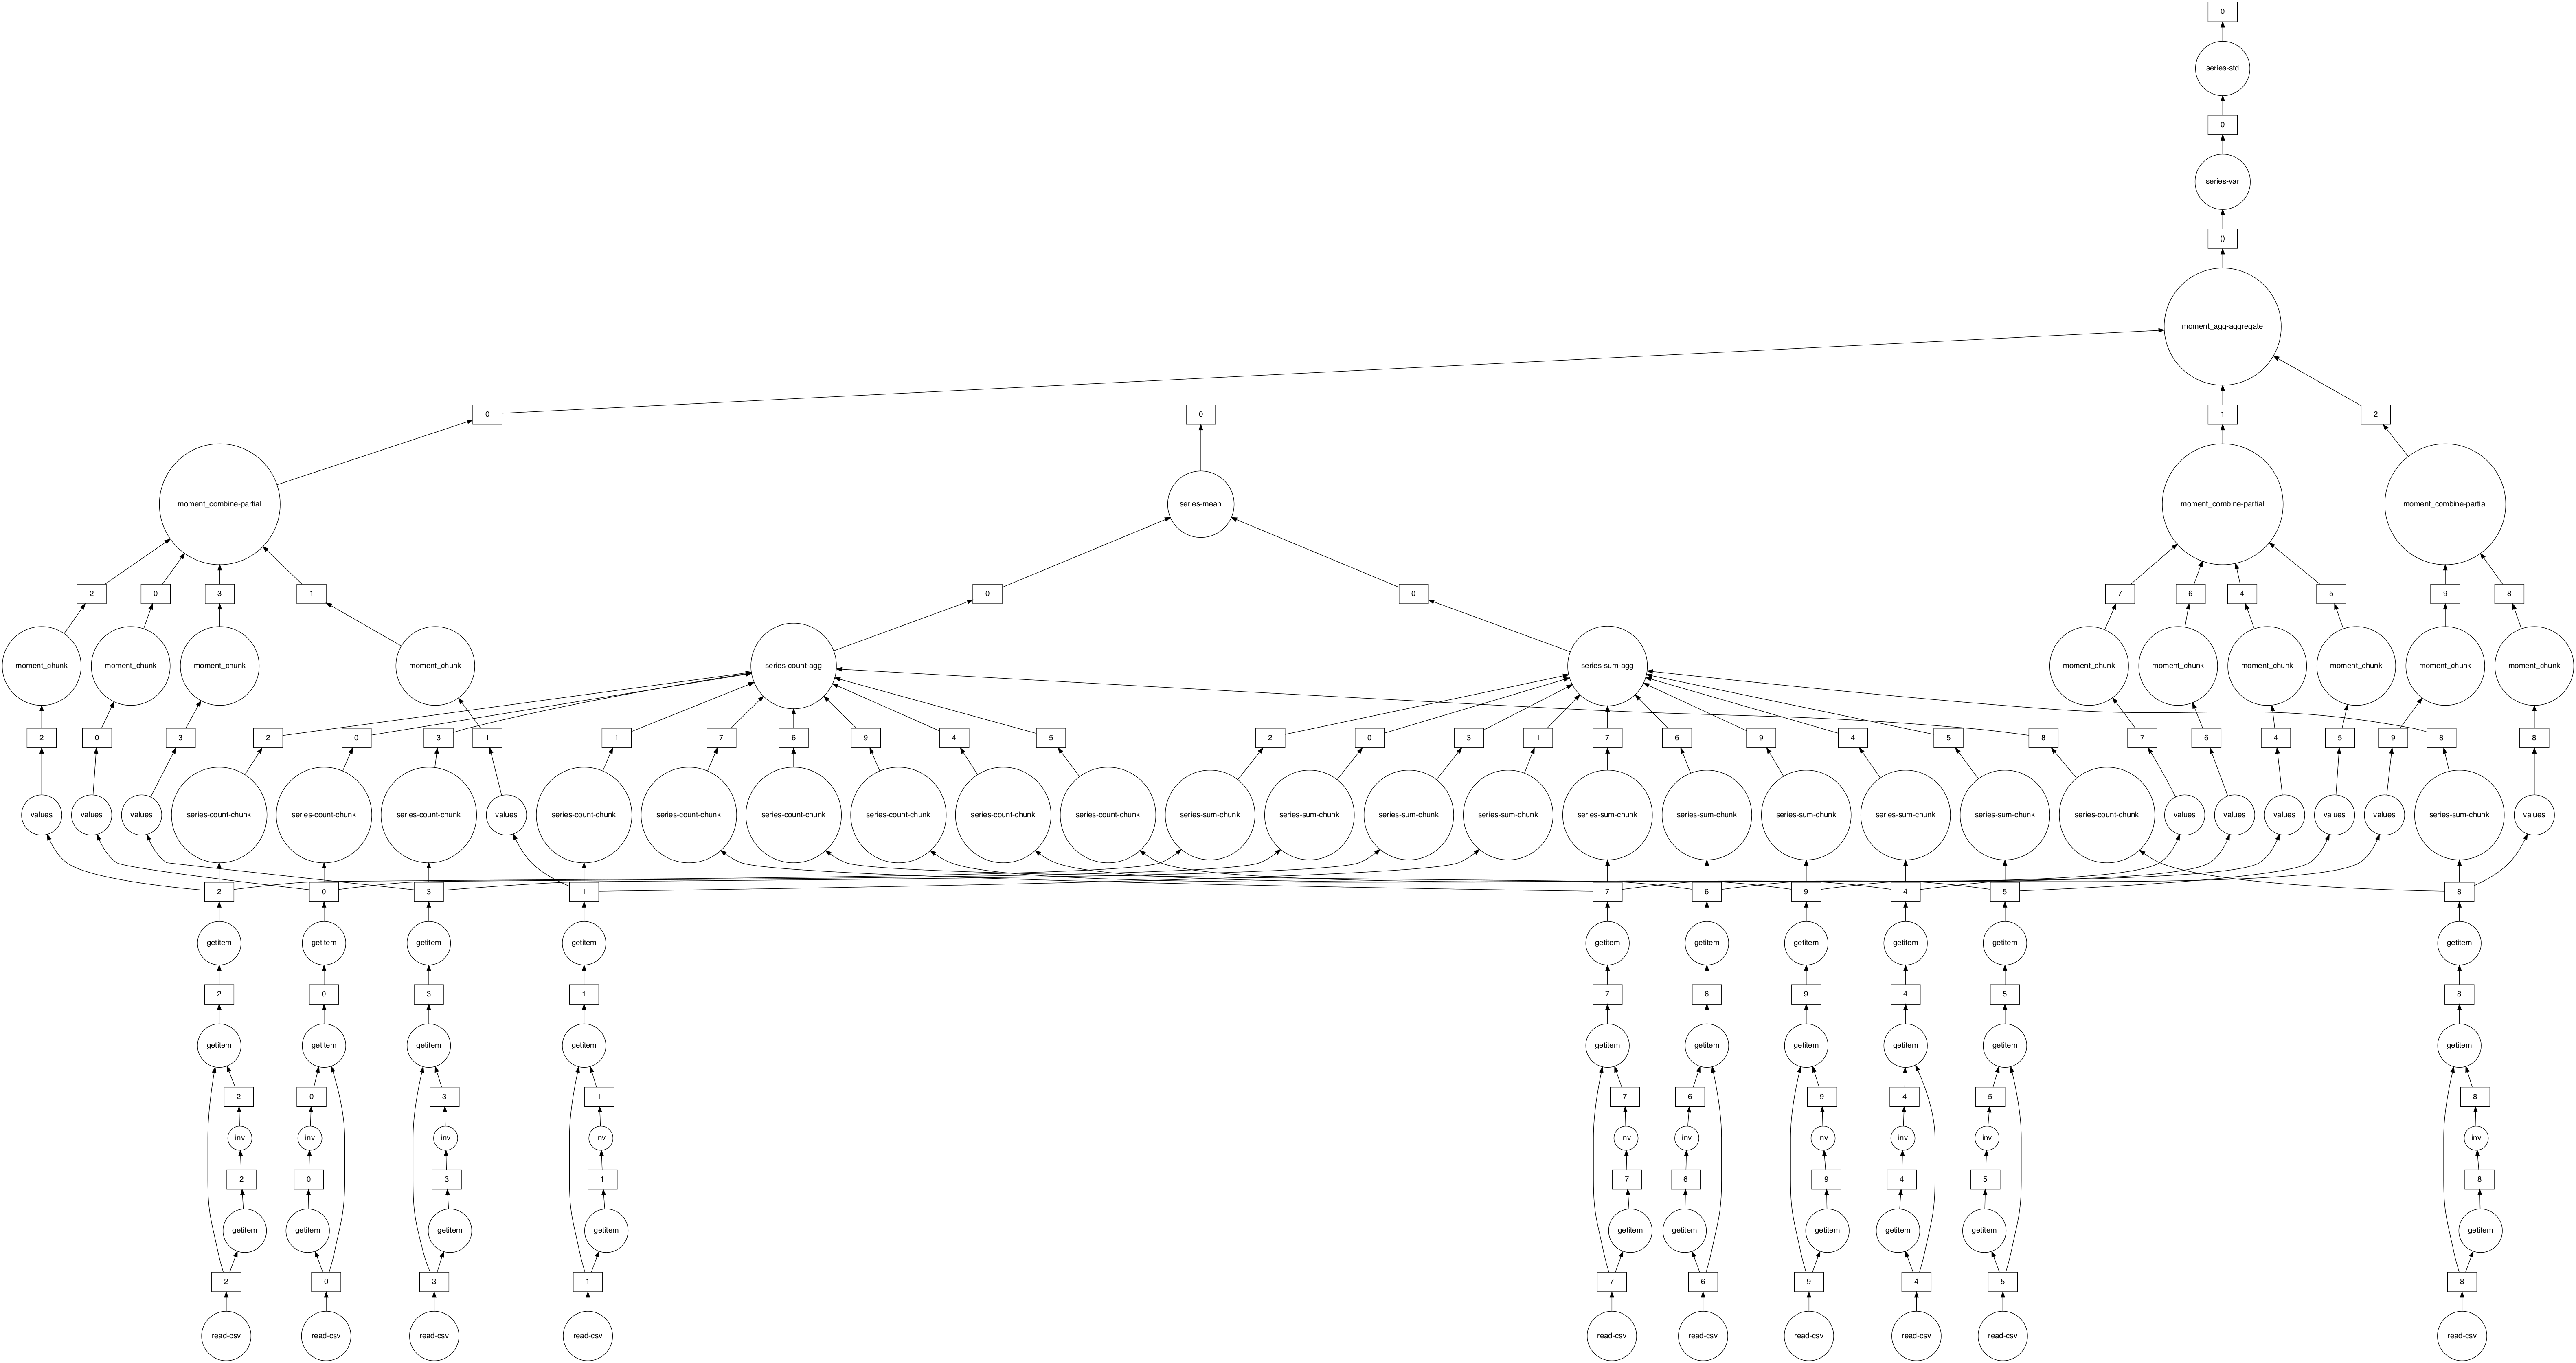

In [23]:
dask.visualize(mean_delay, std_delay)

## The Dask Distributed Scheduler

There are a few different Dask schedulers, but when starting out on your Dask journey you only need to know about the most powerful and feature-complete one: the **distributed scheduler**. This scheduler offers more features and diagnostics. You can think of the distributed scheduler as an advanced scheduler that also does the basic stuff really well.

The distributed scheduler can be used in a cluster as well as locally. Deploying a remote Dask cluster involves additional setup that you can read more about on the Dask [setup documentation](https://docs.dask.org/en/latest/setup.html). Alternatively, you can use [Coiled](https://docs.coiled.io/user_guide/index.html#what-is-coiled) which provides a cluster-as-a-service functionality to provision hosted Dask clusters on demand, and you can try it for free.  

For now, we will set up the scheduler locally. To set up the distributed scheduler locally we need to create a `Client` object, which will let you interact with the "cluster" (local threads or processes on your machine)

In [ ]:
from distributed import Client

client = Client(n_workers=8) #shorthand for creating a 'local cluster' of all your machine's cores
client

## The Dask Dashboard

When we create a distributed scheduler Client, it registers itself as the default Dask scheduler. From now on, all `.compute()` calls will start using the distributed scheduler unless otherwise is specified.

The distributed scheduler has many features that you can learn more about in the Dask distributed documentation but a nice feature to explore is diagnostic the Dashboard. We will be taking a look at the dashboard as we perform computations but for a brief overview of the main components of the dashboard you can check the Dask documentation on diagnosing performance.

If you click on the link of the dashboard on the cell above and run the computation we did before you will see now some action happening on the dashboard.

In [ ]:
%%time
ddf.groupby("DayOfWeek")["DepDelay"].mean().compute()

In [ ]:
client.close()

## Extra resources

- Explore applying custom code to Dask DataFrames: [Dask Tutorial DataFrames](https://github.com/dask/dask-tutorial/blob/main/04_dataframe.ipynb)
- [Dask DataFrame documentation](https://docs.dask.org/en/latest/dataframe.html)
- [Dask DataFrame examples](https://examples.dask.org/dataframe.html)